# Nicht-lineare Trennbarkeit (Kreise)

Im ersten Notebook haben wir gesehen, wie eine **Gerade** zwei Käfer-Arten trennen kann.

Hier erzeugen wir ein Beispiel, bei dem das **nicht** mehr möglich ist:

- Klasse 0: Punkte in einem **inneren Kreis**
- Klasse 1: Punkte in einem **äußeren Ring**

Egal, wie wir die Gerade drehen oder verschieben – sie wird nie beide Klassen perfekt trennen.
Das ist ein Beispiel für **nicht-linear trennbare** Daten.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from matplotlib import animation
from IPython.display import HTML

np.random.seed(42)

# Daten erzeugen: innerer Kreis + äußerer Ring
n_inner = 80
n_outer = 80

# Innerer Kreis (Radius ~1)
angles_inner = np.random.uniform(0, 2*np.pi, n_inner)
r_inner = 1.0 + 0.05 * np.random.randn(n_inner)
x_inner = r_inner * np.cos(angles_inner)
y_inner = r_inner * np.sin(angles_inner)

# Äußerer Ring (Radius ~3)
angles_outer = np.random.uniform(0, 2*np.pi, n_outer)
r_outer = 3.0 + 0.1 * np.random.randn(n_outer)
x_outer = r_outer * np.cos(angles_outer)
y_outer = r_outer * np.sin(angles_outer)

# Features & Labels
X = np.vstack([
    np.column_stack([x_inner, y_inner]),
    np.column_stack([x_outer, y_outer])
])
y = np.hstack([
    np.zeros(n_inner),  # 0 = innen
    np.ones(n_outer)    # 1 = außen
])


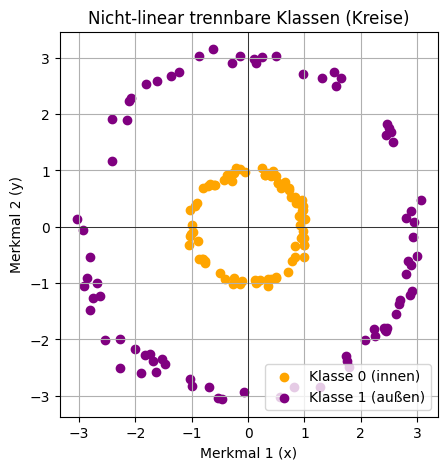

In [8]:
plt.figure(figsize=(5, 5))
plt.scatter(x_inner, y_inner, color='orange', label='Klasse 0 (innen)')
plt.scatter(x_outer, y_outer, color='purple', label='Klasse 1 (außen)')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.gca().set_aspect('equal', 'box')
plt.xlabel('Merkmal 1 (x)')
plt.ylabel('Merkmal 2 (y)')
plt.title('Nicht-linear trennbare Klassen (Kreise)')
plt.grid(True)
plt.legend()
plt.show()

## Lineares Modell – wie bei den Käfern, aber es wird scheitern

Wir verwenden wieder ein **lineares Modell** (SGDClassifier mit logistischem Loss).
Diesmal wird die Gerade aber keine perfekte Trennung schaffen.

Wir beobachten:
- Die Gerade bewegt sich während des Lernens.
- Trotzdem bleiben immer Punkte beider Klassen auf beiden Seiten.

In [9]:
clf = SGDClassifier(
    loss='log_loss',
    learning_rate='constant',
    eta0=0.05,
    max_iter=1,
    tol=None,
    random_state=0,
)

n_epochs = 10
weights_history = []
bias_history = []

for epoch in range(n_epochs):
    clf.partial_fit(X, y, classes=np.array([0, 1]))
    w1, w2 = clf.coef_[0]
    b = clf.intercept_[0]
    weights_history.append((w1, w2))
    bias_history.append(b)
    acc = (clf.predict(X) == y).mean()
    print(f'Epoche {epoch+1:2d}: Accuracy = {acc:.2f}')

print('Gespeicherte Schritte:', len(weights_history))


Epoche  1: Accuracy = 0.60
Epoche  2: Accuracy = 0.60
Epoche  3: Accuracy = 0.60
Epoche  4: Accuracy = 0.60
Epoche  5: Accuracy = 0.60
Epoche  6: Accuracy = 0.60
Epoche  7: Accuracy = 0.60
Epoche  8: Accuracy = 0.60
Epoche  9: Accuracy = 0.60
Epoche 10: Accuracy = 0.60
Gespeicherte Schritte: 10


In [10]:
x_vals = np.linspace(-4, 4, 200)

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(x_inner, y_inner, color='orange', label='Klasse 0 (innen)')
ax.scatter(x_outer, y_outer, color='purple', label='Klasse 1 (außen)')

(line,) = ax.plot([], [], linewidth=2, color='blue', label='lineare Entscheidung')

ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
ax.set_aspect('equal', 'box')
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_xlabel('Merkmal 1 (x)')
ax.set_ylabel('Merkmal 2 (y)')
ax.grid(True)
ax.legend(loc='upper right')

def init():
    line.set_data([], [])
    return (line,)

def update(frame):
    w1, w2 = weights_history[frame]
    b = bias_history[frame]
    if abs(w2) < 1e-6:
        y_vals = np.full_like(x_vals, np.nan)
    else:
        y_vals = -(w1 / w2) * x_vals - b / w2
    line.set_data(x_vals, y_vals)
    ax.set_title(f'Lineares Modell – Epoche {frame+1}')
    return (line,)

anim = animation.FuncAnimation(
    fig,
    update,
    init_func=init,
    frames=len(weights_history),
    interval=500,
    blit=True,
)

plt.close(fig)
HTML(anim.to_jshtml())

## Reflexion

- Bei den **Käferdaten** konnte eine Gerade die Klassen gut trennen.
- Hier (Kreise) ist das nicht möglich – manche Punkte der inneren Klasse liegen immer auf
  der falschen Seite der Linie und umgekehrt.

Die Daten sind **nicht linear trennbar**!

**Frage:** Wie könnte man die Daten so umrechnen, dass sie wieder trennbar werden?

## Nicht-lineare Lösung durch Feature-Transformation

Unsere Kreis-Daten sind im $(x,y)$-Koordinatensystem **nicht linear trennbar**.

Idee: Statt direkt mit $x$ und $y$ zu arbeiten, schauen wir uns den
**Abstand vom Ursprung** an:

$r = \sqrt{x^2 + y^2}$

- Punkte im inneren Kreis haben einen **kleinen** Radius.
- Punkte im äußeren Ring haben einen **größeren** Radius.

In der 1D-Sicht „Radius“ lassen sich die beiden Klassen plötzlich
wieder durch eine **einfache Schwelle** trennen – also nicht-linear
im Originalraum, aber linear im transformierten Raum.


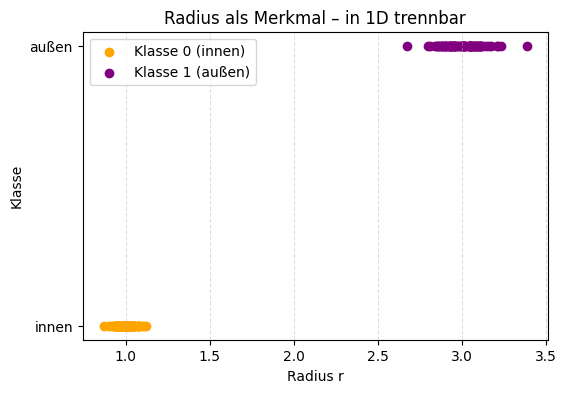

Accuracy im Radius-Raum: 1.00
Entscheidungsradius (Grenze zwischen innen/außen): r ≈ 1.99


In [17]:
from sklearn.linear_model import LogisticRegression

# 1) Radius als neues Merkmal berechnen
r = np.sqrt(X[:, 0]**2 + X[:, 1]**2).reshape(-1, 1)

plt.figure(figsize=(6, 4))
plt.scatter(r[y == 0], y[y == 0], color="orange", label="Klasse 0 (innen)")
plt.scatter(r[y == 1], y[y == 1], color="purple", label="Klasse 1 (außen)")
plt.yticks([0, 1], ["innen", "außen"])
plt.xlabel("Radius r")
plt.ylabel("Klasse")
plt.title("Radius als Merkmal – in 1D trennbar")
plt.grid(True, axis="x", linestyle="--", alpha=0.4)
plt.legend()
plt.show()

# 2) Logistische Regression nur auf dem Radius trainieren
clf_radius = LogisticRegression().fit(r, y)
acc_radius = clf_radius.score(r, y)
print(f"Accuracy im Radius-Raum: {acc_radius:.2f}")

# Entscheidungsgrenze im Radius: w * r + b = 0  -> r = -b / w
w_r = clf_radius.coef_[0][0]
b_r = clf_radius.intercept_[0]
r_boundary = -b_r / w_r
print(f"Entscheidungsradius (Grenze zwischen innen/außen): r ≈ {r_boundary:.2f}")

# 3) Kreis als Entscheidungsgrenze im ursprünglichen (x,y)-Raum einzeichnen
theta = np.linspace(0, 2*np.pi, 300)
x_circle = r_boundary * np.cos(theta)
y_circle = r_boundary * np.sin(theta)

# plt.figure(figsize=(6, 6))
# plt.scatter(x_inner, y_inner, color="orange", label="Klasse 0 (innen)")
# plt.scatter(x_outer, y_outer, color="purple", label="Klasse 1 (außen)")
# plt.plot(x_circle, y_circle, color="black", linewidth=2, label="nicht-lineare Grenze (Kreis)")

# plt.axhline(0, color="black", linewidth=0.5)
# plt.axvline(0, color="black", linewidth=0.5)
# plt.gca().set_aspect("equal", "box")
# plt.xlabel("Merkmal 1 (x)")
# plt.ylabel("Merkmal 2 (y)")
# plt.title("Nicht-lineare Entscheidung durch Kreis im (x,y)-Raum")
# plt.grid(True)
# plt.legend()
# plt.show()


In [18]:
# --- 1) Radius berechnen (falls noch nicht geschehen) ---
r = np.sqrt(X[:, 0]**2 + X[:, 1]**2).reshape(-1, 1)

# --- 2) Lineares Modell nur auf dem Radius ---
clf_r = SGDClassifier(
    loss="log_loss",
    learning_rate="constant",
    eta0=0.1,        # konstante Lernrate
    max_iter=1,
    tol=None,
    random_state=0
)

n_epochs = 20
r_boundaries = []

for epoch in range(n_epochs):
    clf_r.partial_fit(r, y, classes=np.array([0, 1]))

    # Berechne Entscheidungsradius r = -b/w
    w_r = clf_r.coef_[0][0]
    b_r = clf_r.intercept_[0]
    r_boundary = -b_r / w_r

    # --- SANFTER SCHLECHTER START in den ersten 5 Epochen ---
    if epoch < 5:
        # Noise nimmt langsam ab, bis Epoche 5 fast raus
        reduction_factor = 1 - (epoch / 5)      # 1 → 0.2
        noise = np.random.uniform(-2.5, 2.5) * reduction_factor
        r_boundary += noise

    r_boundaries.append(r_boundary)

    acc = clf_r.score(r, y)
    print(f"Epoche {epoch+1:2d}: Accuracy (Radius) = {acc:.2f},  r-Grenze ≈ {r_boundary:.2f}")

# --- 3) Animation vorbereiten ---
theta = np.linspace(0, 2*np.pi, 300)

fig, ax = plt.subplots(figsize=(6, 6))

# Punkte plotten
ax.scatter(x_inner, y_inner, color="orange", label="Klasse 0 (innen)")
ax.scatter(x_outer, y_outer, color="purple", label="Klasse 1 (außen)")

# Leere Kreislinie für Animation
(circle_line,) = ax.plot([], [], color="black", linewidth=2, label="nicht-lineare Grenze (Kreis)")

ax.axhline(0, color="black", linewidth=0.5)
ax.axvline(0, color="black", linewidth=0.5)
ax.set_aspect("equal", "box")
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.grid(True)
ax.legend(loc="upper right")

def init():
    circle_line.set_data([], [])
    return (circle_line,)

def update(frame):
    r_b = r_boundaries[frame]
    x_circle = r_b * np.cos(theta)
    y_circle = r_b * np.sin(theta)

    circle_line.set_data(x_circle, y_circle)
    ax.set_title(f"Nicht-lineare Grenze (Kreis) – Epoche {frame+1}, r ≈ {r_b:.2f}")
    return (circle_line,)

anim = animation.FuncAnimation(
    fig,
    update,
    init_func=init,
    frames=len(r_boundaries),
    interval=500,
    blit=True
)

plt.close(fig)
HTML(anim.to_jshtml())


Epoche  1: Accuracy (Radius) = 1.00,  r-Grenze ≈ 4.06
Epoche  2: Accuracy (Radius) = 1.00,  r-Grenze ≈ 3.43
Epoche  3: Accuracy (Radius) = 1.00,  r-Grenze ≈ 0.92
Epoche  4: Accuracy (Radius) = 1.00,  r-Grenze ≈ 0.98
Epoche  5: Accuracy (Radius) = 1.00,  r-Grenze ≈ 1.45
Epoche  6: Accuracy (Radius) = 1.00,  r-Grenze ≈ 1.85
Epoche  7: Accuracy (Radius) = 1.00,  r-Grenze ≈ 1.86
Epoche  8: Accuracy (Radius) = 1.00,  r-Grenze ≈ 1.86
Epoche  9: Accuracy (Radius) = 1.00,  r-Grenze ≈ 1.87
Epoche 10: Accuracy (Radius) = 1.00,  r-Grenze ≈ 1.87
Epoche 11: Accuracy (Radius) = 1.00,  r-Grenze ≈ 1.87
Epoche 12: Accuracy (Radius) = 1.00,  r-Grenze ≈ 1.88
Epoche 13: Accuracy (Radius) = 1.00,  r-Grenze ≈ 1.88
Epoche 14: Accuracy (Radius) = 1.00,  r-Grenze ≈ 1.88
Epoche 15: Accuracy (Radius) = 1.00,  r-Grenze ≈ 1.88
Epoche 16: Accuracy (Radius) = 1.00,  r-Grenze ≈ 1.89
Epoche 17: Accuracy (Radius) = 1.00,  r-Grenze ≈ 1.89
Epoche 18: Accuracy (Radius) = 1.00,  r-Grenze ≈ 1.89
Epoche 19: Accuracy (Radius)